# Fitting with a neural network

In the Quickstart tutorial, we worked through how to use the PCA-based approach implemented in `cortecs`. Now, let's walk through how to use the neural network-based approach. 

# Setting up the objects

In [1]:
import numpy as np

import cortecs
from cortecs.opac.opac import *
from cortecs.fit.fit import *
from cortecs.fit.fit_pca import *
from cortecs.eval.eval import *

We'll be using the same `Opac` object as in the Quickstart.

In [2]:
T_filename = "temperatures.npy"
P_filename = "pressures.npy"
wl_filename = "wavelengths.npy"

cross_sec_filename = "absorb_coeffs_C2H4.npy"

load_kwargs = {
    "T_filename": T_filename,
    "P_filename": P_filename,
    "wl_filename": wl_filename,
}
opac_obj = Opac(cross_sec_filename, loader="platon", load_kwargs=load_kwargs)

/Users/arjunsavel/Desktop/research/opac_compress/src/cortecs/opac/io.py:156: RuntimeWarning: divide by zero encountered in log10
  cross_section = np.log10(cross_section)


This time, we specify that we'd like to fit the object with the `neural_net` method.

In [3]:
fitter = Fitter(opac_obj, method="neural_net")
fitter

We won't actually fit the entire opacity, though—that would take about 15 hours on a laptop. Instead, let's just fit a single one.

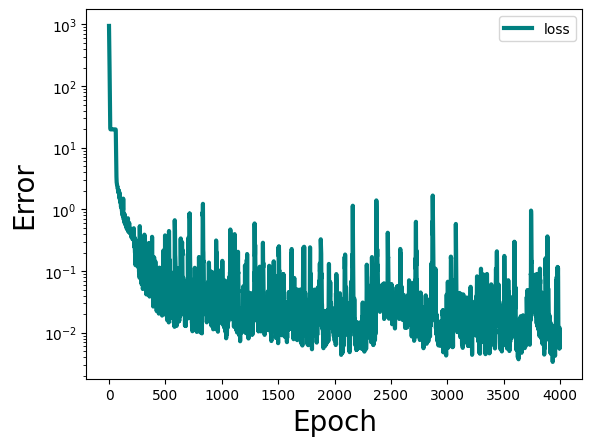

In [4]:
res = cortecs.fit.fit_neural_net.fit_neural_net(
    fitter.opac.cross_section[:, :, -2],
    fitter.opac.T,
    fitter.opac.P,
    None,
    all_wl=False,
    n_layers=3,
    n_neurons=8,
    activation="sigmoid",
    learn_rate=0.04,
    loss="mean_squared_error",
    epochs=4000,
    verbose=0,
    sequential_model=None,
    plot=True,
)

This code shouldn't take more than 15 seconds or so to run.

The above plot tells us how the model performs as it iterates on its weights.

In [5]:
history, neural_network = res

13/13 [==============================] - 0s 460us/step


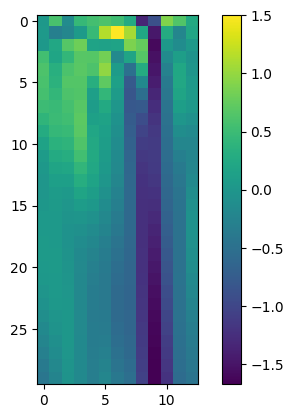

In [6]:
P_unraveled = unravel_data(fitter.opac.P, fitter.opac.T, None, tileboth=True)
T_unraveled = unravel_data(fitter.opac.T, fitter.opac.P, None, tileboth=False)
input_array = np.column_stack([T_unraveled, P_unraveled])

npres = len(fitter.opac.P)
ntemp = len(fitter.opac.T)

predictions = neural_network.predict(input_array)
plt.imshow(
    100
    * (predictions.reshape(ntemp, npres) - fitter.opac.cross_section[:, :, -1])
    / predictions.reshape(ntemp, npres)
)
plt.colorbar()

Awesome! Looks like we have accuracy at better than ~5%. We can tune the architecture of the neural network to achieve greater accuracy, but keep in mind that a larger network means more memory — that is, less efficient compression.

We can save the weights for this individual neural network with the built-in API.

In [7]:
save_neural_network(neural_network, "test_nn.pkl")

Great! We've saved our network to the disk. Let's make sure that evaluating this on the fly (without the neural network API — just the weights and the biases) works out.

First, we load in the weights and the biases.

In [8]:
with open("test_nn.pkl", "rb") as f:
    all_weights, all_biases = pickle.load(f)

Next, we call the `eval_neural_net` method to evaluate the neural net with those weights and biases.

In [9]:
n_layers = len(all_weights)
eval_neural_net(100, 1e-4, n_layers, all_weights, all_biases)

Array([-49.343414], dtype=float32)

Great! And let's check that this matches the prediction we made earlier with the same neural net.

In [10]:
predictions[0]

array([-49.34341], dtype=float32)

Finally, let's do a speed test.

In [11]:
%%timeit
eval_neural_net(2000, 1e-4, n_layers, all_weights, all_biases)

218 µs ± 6.37 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Again, this is slower than simply accessing the array. This is a trade-off you'll have to make depending on your architecture (CPU vs. GPU), desired accuracy, and desired memory performance.